# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 23

**Author 1 (sciper):** Jérémy Baffou (301972)  
**Author 2 (sciper):** Léon Delachaux (296093)   
**Author 3 (sciper):** Martin Dahl (344218)  

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

# Imports

In [2]:
import numpy as np
import cv2 as cv
import skimage.io
import scipy.signal as signal
import skimage.transform
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
%matplotlib inline


---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

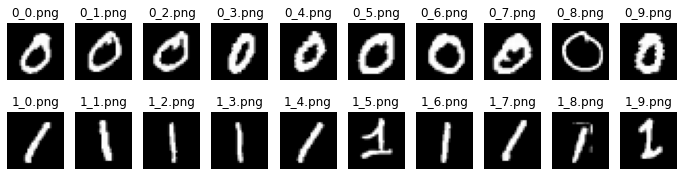

In [3]:
def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

**0. Consider histogram for thresholding**

To work with simpler data, we decided to convert out image to a binary one (belonging or not to the digit). To do so we decided to set up a threshold, and any pixels whose value is above this threshold will be tagged as a digit pixel. We will be interested only in the outer part of the digit and not to the inner part if it exists (like in 0, 4, 6, 8 or 9 digits). Thus, as we simply care about the overal shape and external borders, we can oversmooth a bit to avoid contour detection problems as long as we do not difform too much our image.

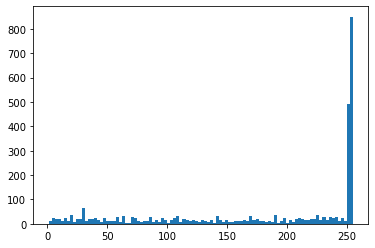

In [4]:
# All images flattened into one row vector
all_images = np.concatenate((ones_im, zeros_im))
all_images_flattened = np.reshape(all_images, (20*28*28))

# Removing zeros since these are obviously not our digits and scew the histogram below
all_images_flattened_no_zeros = np.delete(all_images_flattened, np.where(all_images_flattened == 0)) 

# Histogram
plot = plt.hist(all_images_flattened_no_zeros, bins=100)

Looking at the histogram does not give us a good indication of where to set the threshold, thus this is found empirically. 

**1. Thresholding, setting T by trial**

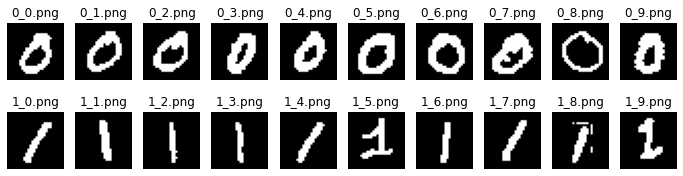

In [5]:
# Thresholding
T = 50

ones_thresholded = ones_im.copy()
zeros_thresholded = zeros_im.copy()
ones_thresholded[ones_thresholded < T] = 0 
ones_thresholded[ones_thresholded != 0] = 1 
zeros_thresholded[zeros_thresholded < T] = 0 
zeros_thresholded[zeros_thresholded != 0] = 1 

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_thresholded, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_thresholded, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

**2. Morphological open to remove noise**

We see that the thresholding has induced some noise in our images (artificial parts and increased shape complexity). As we are interested in the overal shape of the image, we decided to do some morphological opening to remove these artifacts.

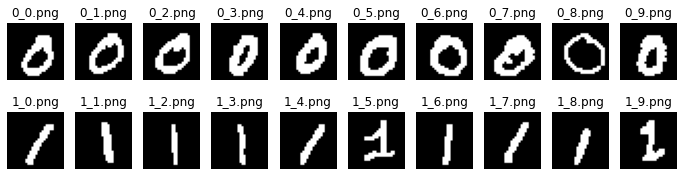

In [6]:
# https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

kernel = np.ones((2,2),np.uint8)

for i in range(10):
    ones_thresholded[i,:] = cv.morphologyEx(ones_thresholded[i,:], cv.MORPH_OPEN, kernel)
    zeros_thresholded[i,:] = cv.morphologyEx(zeros_thresholded[i,:], cv.MORPH_OPEN, kernel)
    
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_thresholded, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_thresholded, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

Some digits end up too thin, this will cause problem with boundary tracking algorithm below. Thats why we dilate it again with a 3x3 kernel:

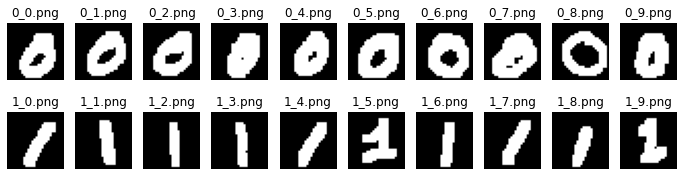

In [7]:
kernel = np.ones((3,3),np.uint8)
for i in range(10):
    ones_thresholded[i,:] = cv.dilate(ones_thresholded[i,:],kernel,iterations = 1)
    zeros_thresholded[i,:] = cv.dilate(zeros_thresholded[i,:],kernel,iterations = 1)
                                       
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_thresholded, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_thresholded, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### Digit processing pipeline

This pipeline sums up the pre-processing on our digit.

In [8]:
def process_digit(im_set):
    # Threshold for binary image
    T = 50
    im_set_thresholded = im_set.copy()
    im_set_thresholded[im_set_thresholded < T] = 0 
    im_set_thresholded[im_set_thresholded != 0] = 1
    # Open to remove noise
    kernel = np.ones((2,2),np.uint8)
    for i in range(im_set.shape[0]):
        im_set_thresholded[i,:] = cv.morphologyEx(im_set_thresholded[i,:], cv.MORPH_OPEN, kernel)
    # Dilate once to have thicker digits
    kernel = np.asarray([[1,1,1],[1,1,1],[1,1,1]]).astype(np.uint8)
    for i in range(im_set.shape[0]):
        im_set_thresholded[i,:] = cv.dilate(im_set_thresholded[i,:],kernel,iterations = 1)
    return im_set_thresholded

ones_thresholded = process_digit(ones_im)
zeros_thresholded = process_digit(zeros_im)

**3. Tracking contours to create sequence u**

To detect our contour we will apply a linear filter which will detect the pixels whose value is 1 but have at least one black neighbour. To have the cleanest contour possible, we will use mathematical morphology to remove parts of the contour which are too thick. We call them stairs because they are composed of three pixels in a shape of a stair. These are not necessary as we can shortcut them by taking a diagonal instead of two movements. Then we will begin with the top-left filtered pixel and walk along the border trigonometric wise and record the order of the contour because it will be important for the fourier descriptors.

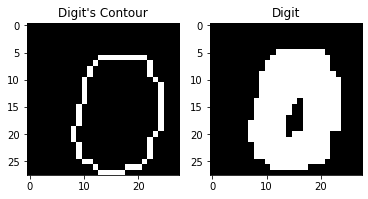

In [9]:
directions = np.asarray([[1,-1],[1,1],[-1,1],[-1,-1],[0,-1],[1,0],[0,1],[-1,0]]) # Trigonometric wise

def get_contour(im):
    """ Apply a linear filter to retrieve the contour points. """
    cw = -1/8
    contour_kernel = np.asarray([[cw,cw,cw],
                            [cw,1,cw],
                            [cw,cw,cw]])
    filtered = signal.convolve2d(im,contour_kernel)
    contour_mask = np.zeros(filtered.shape)
    contour_mask[filtered > 0] = 1
    sharp_contour_mask = sharp_edges(contour_mask)
    return sharp_contour_mask

def get_ordered_contour(im):
    """ Get the outer border of a digit. """
    contour_mask = get_contour(im)
    point = np.asarray([np.where(contour_mask == 1)[0][0],np.where(contour_mask == 1)[1][0]])
    contour = set([tuple(point)])
    id = 0
    contour_id = [(tuple(point),id)] # will be used to order correctly the contour
    new_point = True
    while new_point: 
        new_point = False
        for move in directions:
            candidate = point+move
            if contour_mask[candidate[0],candidate[1]] == 1 and tuple(candidate) not in contour:
                new_point = True
                id += 1
                contour = contour.union(set([tuple(candidate)]))
                contour_id.append((tuple(candidate),id))
                point = candidate
                break
    return list(map(lambda l : l[0], sorted(contour_id,key=lambda t : t[1])))

def sharp_edges(im):
    """ Remove the stairs part in a contour mask. """
    kernel_left_stairs = np.asarray([[0,1,0],[1,1,0],[0,0,0]]).astype(np.uint8)
    left_stairs = cv.morphologyEx(im,
                                  cv.MORPH_ERODE,kernel=kernel_left_stairs)
    kernel_right_stairs = np.asarray([[0,1,0],[0,1,1],[0,0,0]]).astype(np.uint8)
    right_stairs = cv.morphologyEx(im-left_stairs,
                                   cv.MORPH_ERODE,kernel=kernel_right_stairs)
    kernel_up_stairs = np.asarray([[0,0,0],[0,1,1],[0,1,0]]).astype(np.uint8)
    up_stairs = cv.morphologyEx(im-left_stairs-right_stairs,
                                cv.MORPH_ERODE,kernel=kernel_up_stairs)
    kernel_down_stairs = np.asarray([[0,0,0],[1,1,0],[0,1,0]]).astype(np.uint8)
    down_stairs = cv.morphologyEx(im-left_stairs-right_stairs-up_stairs,
                                  cv.MORPH_ERODE,kernel=kernel_down_stairs)
    return im - left_stairs - right_stairs - up_stairs - down_stairs

def complex_contour(im):
    """ Get the contour of the image in complex number form and ordered. """
    contour = get_ordered_contour(im)
    complex_contour = list(map(lambda l: complex(l[0],l[1]), contour))
    return complex_contour 

def show_contour(im):
    """ Plot the contour of the digit. """
    contour = get_ordered_contour(im)
    mask = np.zeros(im.shape)
    for pt in contour:
        mask[pt] = 1
    fig,ax = plt.subplots(1,2)
    ax[0].set_title("Digit's Contour")
    ax[1].set_title("Digit")
    ax[0].imshow(mask,cmap = 'gray')
    ax[1].imshow(im,cmap="gray")

def get_fourier_descriptors(im,n=2):
    """ Compute the fourier descriptors of a digit. """
    imaginary_contour = complex_contour(im)
    fourier_coeffs = fft(imaginary_contour)
    return fourier_coeffs[1:n+1]

show_contour(zeros_thresholded[9])

Note that for our fourier descriptors we kept only the second and third. We kept only two of them to be able to plot the data points on a 2d plane. We kept the second and third because the first one can vary if we translate the image.

#### Plot zeros vs ones

We want now to see if we can draw an hyperplane that nicely separate the two digits classes based on the amplitude of our two fourier descriptors.

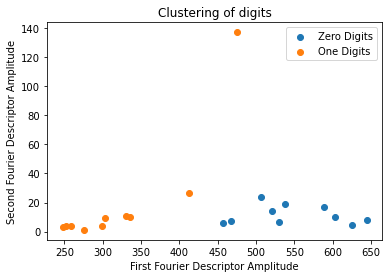

In [10]:
def plot_2_digits(im_set_1,im_set_2):
    set_1_xs = []
    set_1_ys = []
    set_2_xs = []
    set_2_ys = []
    for im_id in range(im_set_1.shape[0]):
        # get descriptors 
        set_1_descriptors = get_fourier_descriptors(im_set_1[im_id])
        set_2_descriptors = get_fourier_descriptors(im_set_2[im_id])
        # get amplitudes for 2d plot
        set_1_x, set_1_y = get_amplitude(set_1_descriptors)
        set_2_x, set_2_y = get_amplitude(set_2_descriptors)
        set_1_xs.append(set_1_x)
        set_1_ys.append(set_1_y)
        set_2_xs.append(set_2_x)
        set_2_ys.append(set_2_y)
    # plot
    fig,ax = plt.subplots()
    ax.set_title("Clustering of digits")
    ax.set_xlabel("First Fourier Descriptor Amplitude")
    ax.set_ylabel("Second Fourier Descriptor Amplitude")
    ax.scatter(set_1_xs,set_1_ys,label="Zero Digits")
    ax.scatter(set_2_xs,set_2_ys,label="One Digits")
    ax.legend()
    
def get_amplitude(descriptors):
    amplitudes = []
    for d in descriptors:
        amplitudes.append(np.sqrt(d.real**2+d.imag**2))
    return amplitudes

plot_2_digits(zeros_thresholded,ones_thresholded)

And indeed we have a nice clustering of our two type of digits. The outlier is the sixth one digit. It has quite a different shape from the other samples (way more wiggly with). Thus it makes sense that it lies in a different region of the subspace:

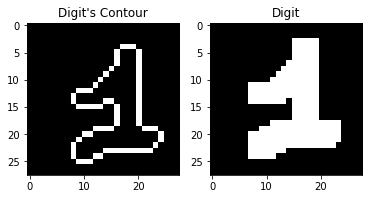

In [11]:
show_contour(ones_thresholded[5])

#### Invariance to various transformations

One of the nice properties of Fourier Descriptors (or at least their ratio) is that they are invariant to some regular transformations of the original image: Translation, rotation and scaling.

##### Rotation

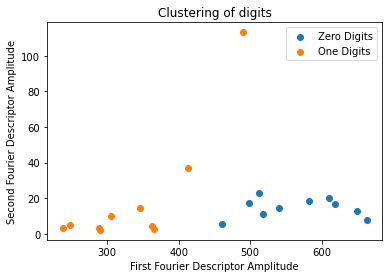

In [12]:
ones_rotated = np.zeros(ones_im.shape,dtype=np.uint8)
zeros_rotated = np.zeros(zeros_im.shape,dtype=np.uint8)
for i in range(ones_rotated.shape[0]):
    ones_rotated[i,:,:] = (255*skimage.transform.rotate(ones_im[i],30)).astype(np.uint8)
    zeros_rotated[i,:,:] = (255*skimage.transform.rotate(zeros_im[i],30)).astype(np.uint8)
ones_rotated = process_digit(ones_rotated)
zeros_rotated = process_digit(zeros_rotated)
plot_2_digits(zeros_rotated,ones_rotated)

We see the exact same plots and amplitudes values, thus our decision is invariant to rotation of digits!

##### Translation

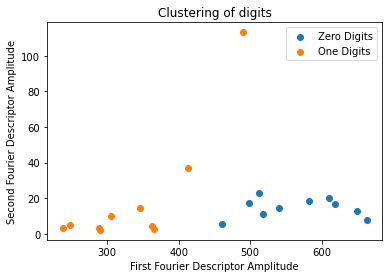

In [13]:
ones_translated = np.zeros(ones_im.shape,dtype=np.uint8)
zeros_translated = np.zeros(zeros_im.shape,dtype=np.uint8)
tform =  skimage.transform.SimilarityTransform(scale=1, rotation=0,
                                      translation=(5, 5))
for i in range(ones_rotated.shape[0]):
    ones_translated[i,:,:] = (255*skimage.transform.warp(ones_im[i], tform)).astype(np.uint8)
    zeros_translated[i,:,:] = (255*skimage.transform.warp(zeros_im[i], tform)).astype(np.uint8)
ones_translated = process_digit(ones_translated)
zeros_translated = process_digit(zeros_translated)
plot_2_digits(zeros_rotated,ones_rotated)

Even with a bit of translation, we get the same values for our two fouriers coefficients. Thus we are also invariant to translation

##### Scaling

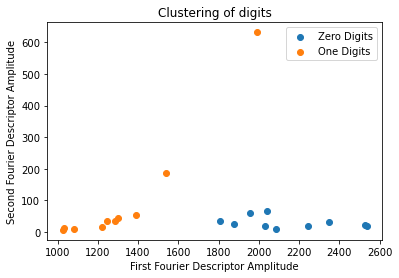

In [14]:
l,m,n = ones_im.shape
alpha = 2
ones_scaled = np.zeros((l,alpha*m,alpha*n),dtype=np.uint8)
zeros_scaled = np.zeros((l,alpha*m,alpha*n),dtype=np.uint8)
for i in range(l):
    ones_scaled[i,:,:] = (255*skimage.transform.rescale(ones_im[i], alpha, mode='reflect')).astype(np.uint8)
    zeros_scaled[i,:,:] = (255*skimage.transform.rescale(zeros_im[i], alpha, mode='reflect')).astype(np.uint8)
ones_scaled = process_digit(ones_scaled)
zeros_scaled = process_digit(zeros_scaled)
plot_2_digits(zeros_scaled,ones_scaled)

We have a similar plot which allows us again to make a distinction between 0 and 1, even if we rescaled the images. The scale of the axis are not the same as compared to our previous plots because the scaling as impacted the amplitude of our coefficients. To be sure that the scaling has not impact our model, we can check that the ratio of two fourier coefficients remains constant through scaling:

In [15]:
pre_scaling = get_fourier_descriptors(ones_thresholded[0])
post_scaling = get_fourier_descriptors(ones_scaled[0])
print(f"Ratio of the fourier descriptors before scaling : {pre_scaling[0]/pre_scaling[1]}")
print(f"Ratio of the fourier descriptors after scaling : {post_scaling[0]/post_scaling[1]}")

Ratio of the fourier descriptors before scaling : (24.46039625886037+22.296266637611165j)
Ratio of the fourier descriptors after scaling : (10.961360773594356+27.422112093285005j)


We can see that we do not get the exact same ratio. It is probably due to the fact that by increasing the image size, we added some portion of the image where we have some fast oscillations due to discretization. Thus we shift the frequency content to higher frequencies.

### 1.3 Additional method (5 pts)

#### PCA

As an alternative method we chose PCA. Principal Components Analysis allows us to retrieve the components which captures most of the variance, and thus information in an image.

In [16]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [17]:
X = np.concatenate((ones_im, zeros_im))
X = np.reshape(X, (20, 28*28))
X = normalize(X, axis=0) # axis=0 normalizes each feature (column-wise)

In [18]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [19]:
transform = pca.transform(X)

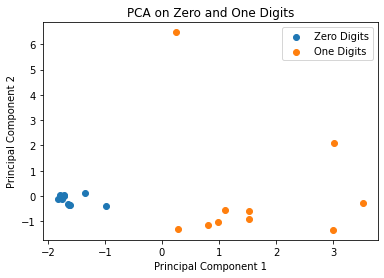

In [20]:
fig,ax = plt.subplots()
ax.set_title("PCA on Zero and One Digits")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.scatter(transform[0:10,0], transform[0:10,1],label="Zero Digits") # Zeros
plt.scatter(transform[10:20,0], transform[10:20,1], label = "One Digits") # Ones
ax.legend();

We can see that this method provides also good results, allowing us to classify correctly (on our dataset) the two classes with a linear classifier.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

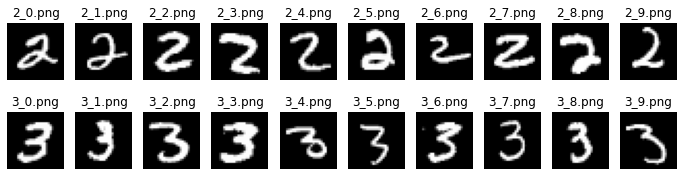

In [21]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

We will process the two and three digits in the same manner as the previous ones. Then we want to see if the two fourier descriptors that we have chose would be enough to distinguish the 4 classes easily.

In [22]:
# Add your implementation and discussion
twos_thresholded = process_digit(twos_im)
three_thresholded = process_digit(threes_im)

In [23]:
def plot_4_digits(im_set_1,im_set_2,im_set_3,im_set_4):
    set_1_xs = []
    set_1_ys = []
    set_2_xs = []
    set_2_ys = []
    set_3_xs = []
    set_3_ys = []
    set_4_xs = []
    set_4_ys = []
    for im_id in range(im_set_1.shape[0]):
        # get descriptors 
        set_1_descriptors = get_fourier_descriptors(im_set_1[im_id])
        set_2_descriptors = get_fourier_descriptors(im_set_2[im_id])
        set_3_descriptors = get_fourier_descriptors(im_set_3[im_id])
        set_4_descriptors = get_fourier_descriptors(im_set_4[im_id])
        # get amplitudes for 2d plot
        set_1_x, set_1_y = get_amplitude(set_1_descriptors)
        set_2_x, set_2_y = get_amplitude(set_2_descriptors)
        set_3_x, set_3_y = get_amplitude(set_3_descriptors)
        set_4_x, set_4_y = get_amplitude(set_4_descriptors)
        set_1_xs.append(set_1_x)
        set_1_ys.append(set_1_y)
        set_2_xs.append(set_2_x)
        set_2_ys.append(set_2_y)
        set_3_xs.append(set_3_x)
        set_3_ys.append(set_3_y)
        set_4_xs.append(set_4_x)
        set_4_ys.append(set_4_y)
    # plot
    fig,ax = plt.subplots()
    ax.set_title("Clustering of digits")
    ax.set_xlabel("First Fourier Descriptor Amplitude")
    ax.set_ylabel("Second Fourier Descriptor Amplitude")
    ax.scatter(set_1_xs,set_1_ys,label="Zero Digits")
    ax.scatter(set_2_xs,set_2_ys,label="One Digits")
    ax.scatter(set_3_xs,set_3_ys,label="Two Digits")
    ax.scatter(set_4_xs,set_4_ys,label="Three Digits")
    ax.legend()

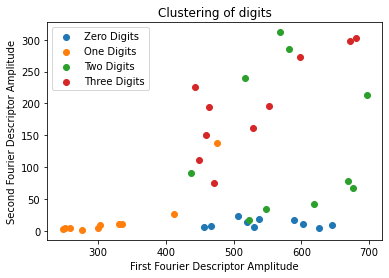

In [24]:
plot_4_digits(zeros_thresholded,ones_thresholded,twos_thresholded,three_thresholded);

We find back the same clustering for our 0 and 1 digits, but now with the addition of the 2 and 3 digits, the clustering is really complex to do if we want to avoid class overlap. Thus our two fourier descriptors does not seem to be enough to classify efficiently four classes of digits.